In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("KODEX200_monthly_data.csv", encoding="utf-8")

### Index는 datetime 형으로 변환하기

In [3]:
df.index = pd.to_datetime(df["Date"])
df.head()

,Date,Open,High,Low,Close,Volume,Change
Date,,,,,,,
2010-01-29,2010-01-29,19052,19066,18668,18742,2717811,-0.026996
2010-02-26,2010-02-26,18611,18683,18514,18559,974615,0.000431
2010-03-31,2010-03-31,19853,19858,19729,19789,883019,-0.003776
2010-04-30,2010-04-30,20331,20403,20313,20377,758179,0.007814
2010-05-31,2010-05-31,18887,19126,18882,19134,1979678,0.012220


### 함수들

In [4]:
# 평균모멘텀 구하기
def 평균모멘텀구하기(data,month):
    result = 0
    for i in range(1,(month+1),1):
        result = data / data.shift(i) + result
    return result/month

# 평균모멘텀 스코어 구하기
def 평균모멘텀스코어구하기(data,month):
    result = 0
    for i in range(1,(month+1),1):
        result = np.where(data / data.shift(i) > 1,1,0) + result
    score = pd.DataFrame(np.round(result/month,2), index=data.index,columns=["12M_Score"]) 
    return score

In [5]:
### 월별 수익
def 월별수익(data):
    return np.round(data/data.shift(1),2)

### 전략 수익 데이타만들기

In [7]:
#1. 자본금 초기화
balance = 1000000

#2. 12개월 평균모멘텀 스코어
# 벤치마크 KODEX200
kodex200 = df["Close"]; kodex200.rename("KODEX200", inplace=True)
score12 = 평균모멘텀스코어구하기(kodex200,12)
# 평균모멘텀스코어와 종목["Close"] 합침
momentum12 = pd.concat([kodex200, score12], axis=1)

#3. system stop = market score, 이동평균으로 구하기, Nan값은 0으로 채움
momentum12["market_score_ma5"] = momentum12["12M_Score"].rolling(window=5).mean().fillna(0)

#4 월별수익
momentum12["월별수익"] = 월별수익(momentum12["KODEX200"])

#4. market score * 잔고 = 투자금액
#5. 투자금액 * 12개월 평균 스코어 = 매수가능금액
#6. 매수가능금액 / 현재가(Close) = 구매가능수량
#7. 구매가능수량 * 현재가(Close) = 매수금액
#8. 잔고 - 매수금액 = 현금
#9. 월별수익 * 매수금액 = 매도금액
#10. 수수료
#11 현금 + 매도금액 = 잔고

스코어금액 = []
매수가능금액 = []
구매수량 = []
매수금액 = []
매도금액 = []
현금 = []
잔고 = [1000000]
수수료 = 0

for i in range(0,len(momentum12)):
    # 마켓스코어 계산을 통해 현금:투자금액 비율을 구한다.
    스코어금액.append(잔고[i] * momentum12["market_score_ma5"][i])
    # 해당 종목의 12개월 평균모멘텀 점수만큼 매수한다.
    매수가능금액.append(스코어금액[i] * momentum12["12M_Score"][i])
    구매수량.append(round(매수가능금액[i] / momentum12["KODEX200"][i]))
    매수금액.append(구매수량[i] * momentum12["KODEX200"][i])
    # 매수금액 : 현금을 구한다
    현금.append(잔고[i] - 매수금액[i])
    # 이번달 투자금액 * 다음달 월별수익
    try:
        # 이번달 수익은 다음달 월별수익으로 알수있다.
        매도 = 매수금액[i] * momentum12["월별수익"][i+1]
    except IndexError:
        매도 = 매수금액[i]
    # 수수료를 반영하여 실전 평가한다.
    매도금액.append(매도 - 수수료)
    # 다음달 잔고는 이번달 현금과 매도금액이다.
    잔고.append(현금[i] + 매도금액[i])

In [8]:
# Series & DataFrame 합치기
스코어금액 = pd.Series(스코어금액,index=momentum12.index, name = "스코어금액")
매수가능금액 = pd.Series(매수가능금액,index=momentum12.index, name = "매수가능금액")
구매수량 = pd.Series(구매수량,index=momentum12.index, name = "구매수량")
매수금액 = pd.Series(매수금액,index=momentum12.index, name = "매수금액")
매도금액 = pd.Series(매도금액,index=momentum12.index, name = "매도금액")
현금 = pd.Series(현금,index=momentum12.index, name = "현금")
# 마지막 데이터 저장시 길이가 +1만큼 길어져 삭제함
del 잔고[-1]
잔고 = pd.Series(잔고,index=momentum12.index, name = "잔고")

momentum12 = pd.concat([momentum12,스코어금액,매수가능금액,구매수량,매수금액,매도금액,현금,잔고], axis=1)
momentum12.tail()

,KODEX200,12M_Score,market_score_ma5,월별수익,스코어금액,매수가능금액,구매수량,매수금액,매도금액,현금,잔고
Date,,,,,,,,,,,
2018-09-28,30033,0.25,0.132,1.01,141170.76336,35292.690840,1.0,30033.0,26429.04,1039442.48,1069475.48
2018-10-31,26390,0.00,0.066,0.88,70347.52032,0.000000,0.0,0.0,0.00,1065871.52,1065871.52
2018-11-30,27160,0.08,0.082,1.03,87401.46464,6992.117171,0.0,0.0,0.00,1065871.52,1065871.52
2018-12-31,26580,0.08,0.098,0.98,104455.40896,8356.432717,0.0,0.0,0.00,1065871.52,1065871.52
2019-01-31,26215,0.00,0.082,0.99,87401.46464,0.000000,0.0,0.0,0.00,1065871.52,1065871.52


### csv파일로 저장하기

In [9]:
momentum12.to_csv("kodex200.csv",encoding="euc_kr", sep=",")

### 수익률 구하기

In [10]:
# 포트폴리오, CAGR구하기
# The $1,000 would be the F in our formula, L would be $1,980 and N would be 6 (number of years).
y = momentum12.index.year.unique()
CAGR = (momentum12["잔고"][-1]/momentum12["잔고"][0])**(1/len(y))-1
print ("포트폴리오 CAGR {:.2%} ".format(CAGR))

# KODEX200, CAGR구하기
# The $1,000 would be the F in our formula, L would be $1,980 and N would be 6 (number of years).
y = momentum12.index.year.unique()
CAGR = (momentum12["KODEX200"][-1]/momentum12["KODEX200"][0])**(1/len(y))-1
print ("KODEX200 CAGR {:.2%} ".format(CAGR))

포트폴리오 CAGR 0.64% 
KODEX200 CAGR 3.41% 


In [11]:
# 포트폴리오 MDD 구하기
# We are going to use a trailing 252 trading day window
window = len(momentum12)

# Calculate the max drawdown in the past window days for each day in the series.
# Use min_periods=1 if you want to let the first 252 days data have an expanding window
Roll_Max = momentum12['잔고'].rolling(window, min_periods=1).max()
Roll_Max.rename("Roll_Max", inplace=True)
Daily_Drawdown = momentum12['잔고']/Roll_Max - 1.0
Daily_Drawdown.rename("Daily_Drawdown", inplace=True)

# Next we calculate the minimum (negative) daily drawdown in that window.
# Again, use min_periods=1 if you want to allow the expanding window
Max_Daily_Drawdown = Daily_Drawdown.rolling(window, min_periods=1).min()
Max_Daily_Drawdown.rename("Max_Daily_Drawdown", inplace=True)
print ("포트폴리오 MDD {:.2%}".format(Max_Daily_Drawdown[-1]))

# KODEX200 MDD 구하기
# We are going to use a trailing 252 trading day window
window = len(momentum12)

# Calculate the max drawdown in the past window days for each day in the series.
# Use min_periods=1 if you want to let the first 252 days data have an expanding window
Roll_Max = momentum12['KODEX200'].rolling(window, min_periods=1).max()
Roll_Max.rename("Roll_Max", inplace=True)
Daily_Drawdown = momentum12['KODEX200']/Roll_Max - 1.0
Daily_Drawdown.rename("Daily_Drawdown", inplace=True)

# Next we calculate the minimum (negative) daily drawdown in that window.
# Again, use min_periods=1 if you want to allow the expanding window
Max_Daily_Drawdown = Daily_Drawdown.rolling(window, min_periods=1).min()
Max_Daily_Drawdown.rename("Max_Daily_Drawdown", inplace=True)
print ("KODEX200 MDD {:.2%}".format(Max_Daily_Drawdown[-1]))

포트폴리오 MDD -22.76%
KODEX200 MDD -20.68%


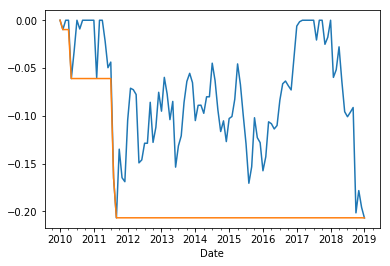

In [12]:
# Plot the results
Daily_Drawdown.plot()
Max_Daily_Drawdown.plot()

### 그래프 그리기

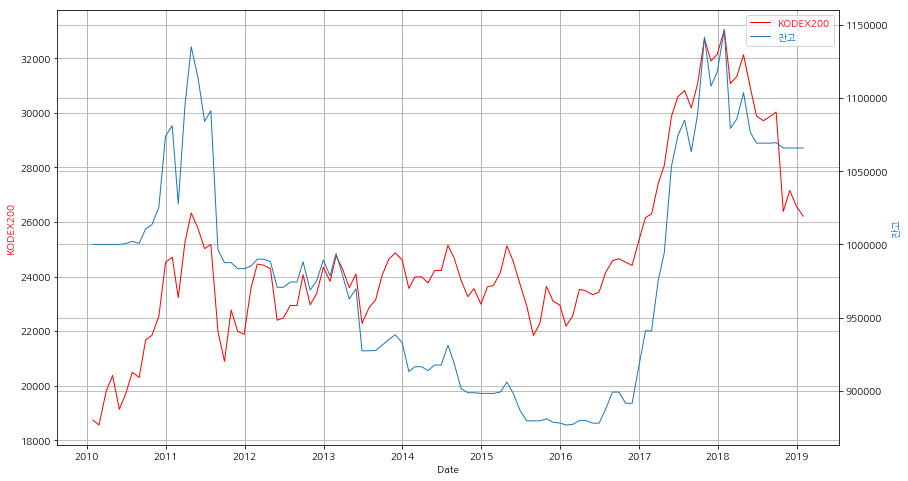

In [19]:
from mpl_toolkits.axes_grid1 import host_subplot
import matplotlib.pyplot as plt
from matplotlib import rc, font_manager
rc("font", family="NanumGothic")

plt.rcParams["figure.figsize"] = (14,8)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.grid'] = True 

host = host_subplot(111)
par = host.twinx()

host.set_xlabel("Date")
host.set_ylabel("KODEX200")
par.set_ylabel("잔고")

p1, = host.plot(momentum12["KODEX200"], label="KODEX200",color = "R")
p2, = par.plot(momentum12["잔고"], label="잔고")
#p2, = par.plot(momentum6["KODEX200"], label="6Score")

leg = plt.legend()

host.yaxis.get_label().set_color("R")
leg.texts[0].set_color("R")

par.yaxis.get_label().set_color(p2.get_color())
leg.texts[1].set_color(p2.get_color())

plt.show()

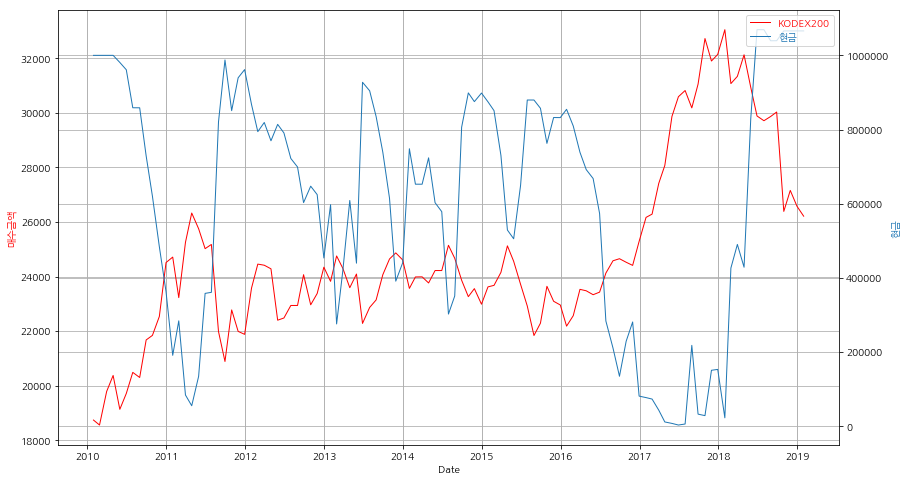

In [18]:
from mpl_toolkits.axes_grid1 import host_subplot
import matplotlib.pyplot as plt
from matplotlib import rc, font_manager
rc("font", family="NanumGothic")

plt.rcParams["figure.figsize"] = (14,8)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.grid'] = True 

host = host_subplot(111)
par = host.twinx()

host.set_xlabel("Date")
host.set_ylabel("매수금액")
par.set_ylabel("현금")

p1, = host.plot(momentum12["KODEX200"], label="KODEX200",color = "R")
p2, = par.plot(momentum12["현금"], label="현금")
#p2, = par.plot(momentum6["KODEX200"], label="6Score")

leg = plt.legend()

host.yaxis.get_label().set_color("R")
leg.texts[0].set_color("R")

par.yaxis.get_label().set_color(p2.get_color())
leg.texts[1].set_color(p2.get_color())

plt.show()

### 수익곡선 이평구하기

In [14]:
# 이평 구하기
ma3 = momentum12["KODEX200"].rolling(window=3).mean()
ma4 = momentum12["KODEX200"].rolling(window=4).mean()
ma5 = momentum12["KODEX200"].rolling(window=5).mean()  # 5개월
ma6 = momentum12["KODEX200"].rolling(window=6).mean()

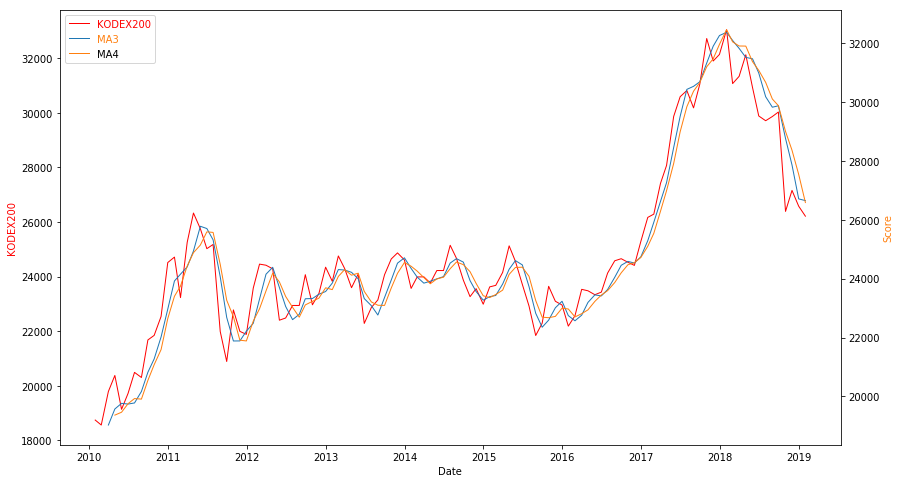

In [15]:
# 그래프 그리기
from mpl_toolkits.axes_grid1 import host_subplot
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (14,8)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.grid'] = False 

host = host_subplot(111)
par = host.twinx()

host.set_xlabel("Date")
host.set_ylabel("KODEX200")
par.set_ylabel("Score")

p1, = host.plot(momentum12["KODEX200"], label="KODEX200",color = "R")
#p2, = par.plot(momentum12["score"], label="12Score")
p2, = par.plot(ma3, label="MA3")
p2, = par.plot(ma4, label="MA4")
#p2, = par.plot(ma5, label="MA5")
#p2, = par.plot(ma6, label="MA")

leg = plt.legend()

host.yaxis.get_label().set_color("R")
leg.texts[0].set_color("R")

par.yaxis.get_label().set_color(p2.get_color())
leg.texts[1].set_color(p2.get_color())

plt.show()